# A Guided Tour of Ray Core: Ray's Multiprocessing Pool

© 2019-2022, Anyscale. All Rights Reserved

📖 [Back to Table of Contents](./ex_00_tutorial_overview.ipynb)<br>
➡ [Next notebook](./ex_06_ray_api_calls.ipynb) <br>
⬅️ [Previous notebook](./ex_04_remote_classes_revisited.ipynb) <br>

### Overview

Ray's [Distributed multiprocessing Pool](https://docs.ray.io/en/latest/multiprocessing.html) makes it easy to scale existing Python applications that use Python's standard [`multiprocessing.Pool`](https://docs.python.org/3/library/multiprocessing.html). By leveraging scalable and stateful *Ray Actors*, Ray supports running distributed python programs with the **multiprocessing.Pool** API. Each actor in a pool runs on a [worker node's](https://docs.ray.io/en/latest/ray-core/actors.html#faq-actors-workers-and-resources) dedicated process, instead of a local process on a single host. Using many processes on many nodes' cores scales existing applications from a single node to a cluster.

<img src="images/dist_multi_pool.png" width="60%" height="33%">

### Learning objectives
In this this tutorial, you will learn how to use:

 * Ray's replacement for Python's normal `Multiprocessing.pool` library 
 * Understand various strategies for scaling CPU bound tasks
 * Undertand the pros and cons of each
 
 
#### Scaling CPU bound tasks using four different strategies:

 1. serial approach for a CPU bound task
 2. multi-threaded approach for a CPU bound task
 3. multiprocess approach for a CPU bound task
 4. Ray distributed multiprocess approach for a CPU bound task
 

Let's have a go ....

In [1]:
import concurrent.futures as mt
import multiprocessing as mp
import numpy as np
import logging
import time
import ray
from ray.util.multiprocessing import Pool
from defs import get_cpu_count, is_prime, f_py_image_signal, f_ray_image_signal
from PIL import Image

In [2]:
NUM = 2000000

### 1. A serial approach for a CPU bound task to compute prime numbers

In [3]:
start = time.time()
prime_numbers = [n for n in range(NUM) if is_prime(n)]
end = time.time()
print(f"Serial access: Time elapsed: {end - start:4.2f} sec to compute all primes in {NUM} are {len(prime_numbers)} ")

Serial access: Time elapsed: 6.07 sec to compute all primes in 2000000 are 148935 


### 2. A multi-threaded approach for a CPU bound task

Python comes with the [Global Interpreter Lock (GIL)](https://realpython.com/python-gil/). While you can spawn as many threads, Python GIL ensures that only one of those threads will ever be executing at any given time. For a CPU bound process, you'll only have a single thread execute, meaning only a single thread will execute computing a prime number.

**Note**: The duration is longer than serial approach.

In [4]:
cpu_count = get_cpu_count()
cpu_count

10

In [5]:
start = time.time()
with mt.ThreadPoolExecutor(cpu_count) as executor:
    prime_numbers = executor.map(is_prime, list(range(NUM)))
end = time.time()
print(f"Multi Threaded access: Time elapsed: {end - start:4.2f} sec to compute all primes in {NUM} are {sum(list(prime_numbers))}")

Multi Threaded access: Time elapsed: 26.41 sec to compute all primes in 2000000 are 148935


### 3. A multiprocess approach for a CPU bound task

In a multiprocess setting, you are not encumbered by the GIL, as each process runs on a seperate core. This ought to be much faster than the above two strategies.

**Note**: Multiprocessing pool does not work in [IPython environments](https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror/42383397#42383397https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror/42383397#42383397). You have to define 
the function in an external file.

In [6]:
# Let's try multiprocess for each core, without being hindered by the GIL
# Since this is CPU bound and not I/O bound task, we should get better performance than the serial and threading
#
start = time.time()
mp_pool = mp.Pool(cpu_count)
with mp_pool as p:
    prime_numbers = p.map(is_prime, list(range(NUM)))
end = time.time()
mp_pool.terminate()
print(f"Multi Process access: Time elapsed: {end - start:4.2f} sec to compute all primes in {NUM} are {sum(list(prime_numbers))}")

Multi Process access: Time elapsed: 2.02 sec to compute all primes in 2000000 are 148935


### 4. Ray distributed multiprocess approach for a CPU bound task

This is most beneficial when your task is compute-intensive and you wish to scale horizontally across a large number of clusters. There lies the power and merit of using Ray's replacement for `multiprocessing.pool`. 

For certain workloads such as intensive scientific numberical computation and image processing workloads, Ray's MPs scales with both single-node, multi-cores and multi-node, multi-cores. Read the [blog for benchmarks](https://towardsdatascience.com/10x-faster-parallel-python-without-python-multiprocessing-e5017c93cce1)

In [7]:
if ray.is_initialized:
    ray.shutdown()
ray.init(logging_level=logging.ERROR)

Python version:,3.8.13
Ray version:,2.2.0
Dashboard:,http://127.0.0.1:8265


In [8]:
# Let's try that with Ray multiprocessing pool.
ray_pool = Pool(cpu_count)
lst = list(range(NUM))
results = []
start = time.time()
for result in ray_pool.map(is_prime, lst):
    results.append(result)
end = time.time()
ray_pool.terminate()
print(f"Ray Distributed Multi Process access: Time elapsed: {end - start:4.2f} sec to compute all primes in {NUM} are {sum(results)}")

Ray Distributed Multi Process access: Time elapsed: 3.17 sec to compute all primes in 2000000 are 148935


Well, what happened here? Why is this a bit slower than the Python MP pool? Let's try another example where it's more compute intensive, takes
longer to compute, and parallelizing amortizes over time.

### Compute intensive operation like image processing

#### Python's multiprocessing is slower:
 * Python uses pickle to serialize large objects when passing them between processes.
 * This approach requires each process to create its own copy of the data, which adds substantial memory usage and compute overhead for expensive deserialization.
 *  Ray avoids all this by using the [Apache Arrow data layout]((https://arrow.apache.org/) for zero-copy serialization along with the Plasma store.

In [9]:
import pylab as plt

Python MP Image processing convolved 200 images: Time elapsed: 40.87 sec


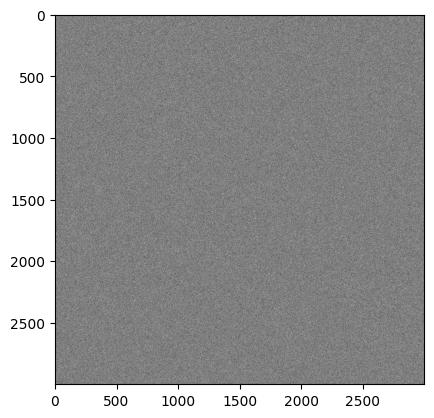

In [10]:
# Create a Python MP pool == number of cores
mp_pool = mp.Pool(cpu_count)

# Create random filters for image convolving 
filters = [np.random.normal(size=(4, 4)) for _ in range(cpu_count)]
total_conv_images = []
start = time.time()
for _ in range(20):
    imarray = np.random.rand(3000, 3000) * 255
    im = Image.fromarray(imarray.astype('uint8')).convert('RGBA')
    conv_images = mp_pool.map(f_py_image_signal, zip(cpu_count * [imarray], filters))
    total_conv_images.append(conv_images)
end = time.time()
plt.imshow(im)
mp_pool.terminate()
print(f"Python MP Image processing convolved {len(total_conv_images) * cpu_count} images: Time elapsed: {end - start:4.2f} sec")

#### Ray's multiprocessing faster:

* Ray's MP uses the shared object store to share data among processes on the same node.
* Ray's MP leverages [Apache Arrow](https://arrow.apache.org/) for efficient data handling.
* Numpy arrays are backed by shared memory without having to deserialize or copy the values.
* All this saves overhead of ser/der and allows zero-copy share among processes on the same node.

Ray MP Image processing convolved 200 images : Time elapsed: 9.66 sec


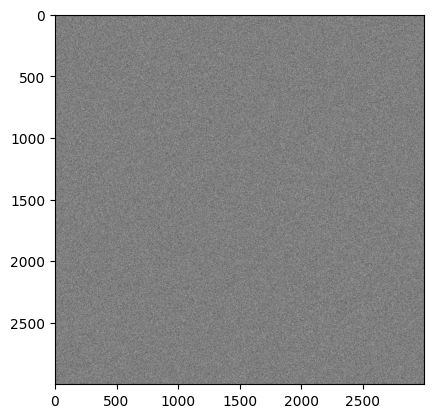

In [11]:
# Create Ray MP pool == number of cores
ray_pool = Pool(cpu_count)

# Create random filters for image convolving 
filters = [np.random.normal(size=(4, 4)) for _ in range(cpu_count)]
total_conv_images = []
start = time.time()
for _ in range(20):
    imarray = np.random.rand(3000, 3000) * 255
    im = Image.fromarray(imarray.astype('uint8')).convert('RGBA')
    conv_images = ray_pool.map(f_ray_image_signal, zip(cpu_count * [imarray], filters))
    total_conv_images.append(conv_images)
end = time.time()
ray_pool.terminate()
plt.imshow(im)
print(f"Ray MP Image processing convolved {len(total_conv_images) * cpu_count} images : Time elapsed: {end - start:4.2f} sec")

In [12]:
ray.shutdown()

### Homework

Read and work through the these references to see the power of Ray multiprocessing over the cluster with multiple nodes, multiple cores. It shines with compute intensive tasks, such as image processing and numerical computations. 

### References

 * [10x Faster Parallel Python Without Python Multiprocessing](https://towardsdatascience.com/10x-faster-parallel-python-without-python-multiprocessing-e5017c93cce1)
 * [Parallelizing Python Code](https://www.anyscale.com/blog/parallelizing-python-code)
 * [How use python for multi-threading and multi-processing applications](https://medium.com/towards-artificial-intelligence/the-why-when-and-how-of-using-python-multi-threading-and-multi-processing-afd1b8a8ecca)

<img src ="https://miro.medium.com/max/1200/1*BXnuxGm7vYUh1pfwbTy-XA.jpeg">

### Next step

Let's take a tour of the [Ray APIs and Tips & Tricks](ex_06_ray_api_calls.ipynb).

📖 [Back to Table of Contents](./ex_00_tutorial_overview.ipynb)<br>
➡ [Next notebook](./ex_06_ray_api_calls.ipynb) <br>
⬅️ [Previous notebook](./ex_04_remote_classes_revisited.ipynb) <br>